## Study of the dataset from TrackML (kaggle)

https://www.kaggle.com/competitions/trackml-particle-identification

Only event000001000 will be used for this study.
The event information is divided into 4 csv files.
* cells - hit_id and channel that observed the hit (specific id for the pixel), alongside the observed value. This will be neglected in our study
* hits - hit position, hit_id and module that detected the particle
* particles - reconstructed particles, with their momentum and velocity information. This will be neglected in our study
* truth - mc truth of the hits: hits are associated with a particle (this is basically the hit-track association which is the goal of this study)

An entire event contains ~120k hits. 
Let's begin with drawing a single track on the detector.

In [9]:
import pandas as pd
import numpy as np
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt
import itertools 

import sys
sys.path.append('/Users/glucia/Projects/DeepLearning/TrackingML')
from utils.terminal_colors import TerminalColors as tc
from core.geometry import DetectorGeometry

In [3]:
hits = pd.read_csv('../../data/train_1/event000001000-hits.csv')
particles = pd.read_csv('../../data/train_1/event000001000-particles.csv')
mc_truth = pd.read_csv('../../data/train_1/event000001000-truth.csv')

print(tc.BOLD+'Hits'+tc.RESET+'\n', hits.head())
print(tc.BOLD+'\nParticles'+tc.RESET+'\n', particles.head())
print(tc.BOLD+'\nMC truth'+tc.RESET+'\n', mc_truth.head())

Hits
    hit_id        x         y       z  volume_id  layer_id  module_id
0       1 -64.4099 -7.163700 -1502.5          7         2          1
1       2 -55.3361  0.635342 -1502.5          7         2          1
2       3 -83.8305 -1.143010 -1502.5          7         2          1
3       4 -96.1091 -8.241030 -1502.5          7         2          1
4       5 -62.6736 -9.371200 -1502.5          7         2          1

Particles
         particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   

          pz  q  nhits  
0  -0.203492 -1      8  
1   2.010060  1     11  
2   0.683881 -1      0  
3   0.991616  1  

particle_id begin from some high number. The particle_id 0 is used to mark fake tracks. 
We will begin to inspect the first particle with non-zero particle_id in the dataset.

In [4]:
print(tc.BOLD+'\nParticle with particle_id 22525763437723648'+tc.RESET+'\n', particles.query('particle_id == 22525763437723648', inplace=False))
selected_particle_truth = mc_truth.query('particle_id == 22525763437723648', inplace=False)
print(tc.BOLD+'\nMC truth of the particle with particle_id 22525763437723648'+tc.RESET+'\n', selected_particle_truth)
print('\nNumber of hits of the particle with particle_id 22525763437723648:', selected_particle_truth.shape[0])

# create a subset of hits for the selected particle
selected_hits = hits[hits['hit_id'].isin(selected_particle_truth['hit_id'])]
print(tc.BOLD+'\nHits of the particle with particle_id 22525763437723648'+tc.RESET+'\n', selected_hits)


Particle with particle_id 22525763437723648
            particle_id        vx        vy       vz       px        py  \
520  22525763437723648 -0.015802  0.006381  1.16279 -0.56967 -0.011187   

         pz  q  nhits  
520 -15.496  1     10  

MC truth of the particle with particle_id 22525763437723648
       hit_id        particle_id       tx        ty      tz       tpx  \
1          2  22525763437723648 -55.3385  0.630805 -1502.5 -0.570605   
1419    1420  22525763437723648 -55.1544  0.621779 -1497.5 -0.569794   
1459    1460  22525763437723648 -47.9881  0.315591 -1302.5 -0.568883   
3169    3170  22525763437723648 -47.8041  0.308733 -1297.5 -0.571445   
3233    3234  22525763437723648 -40.6261  0.087326 -1102.5 -0.569940   
5342    5343  22525763437723648 -40.4422  0.082538 -1097.5 -0.570204   
5423    5424  22525763437723648 -35.4759 -0.024284  -962.5 -0.569773   
5481    5482  22525763437723648 -35.3101 -0.027160  -958.0 -0.571644   
7866    7867  22525763437723648 -35.2917 -0.027

Text(0.5, 0, 'z (mm)')

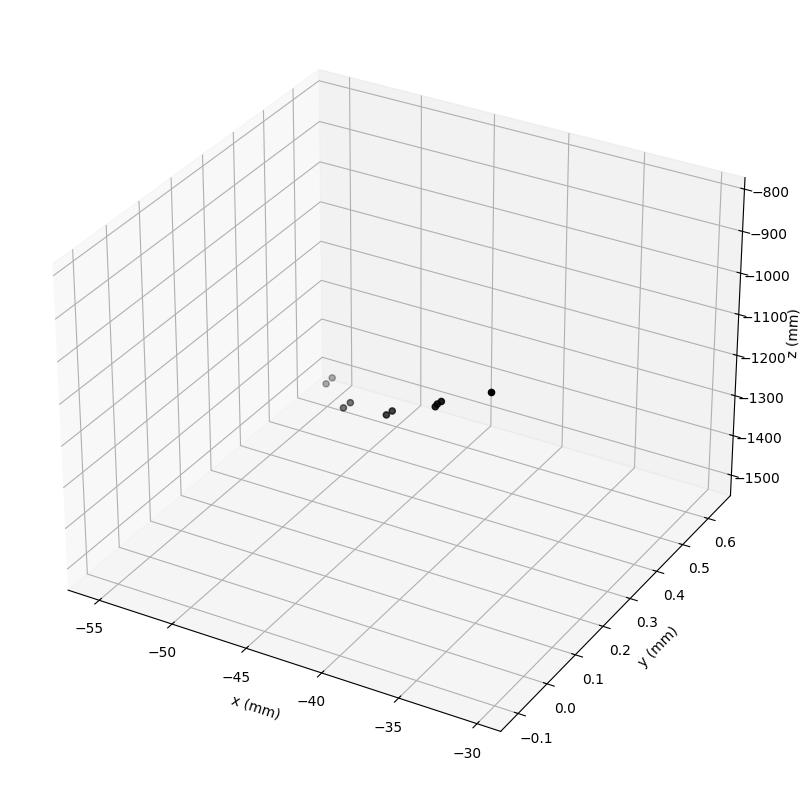

In [56]:
# particle trajectory
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(selected_hits['x'], selected_hits['y'], selected_hits['z'], c='k', marker='o', label='hits')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

The particle follows a curved trajectory inside magnetic field. 
Its trajectory can be obtained by fitting its hits with a polynomial.

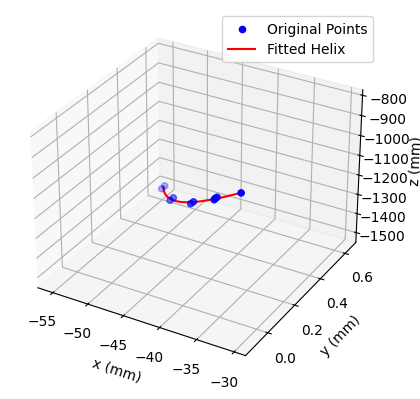

In [60]:
# Separate the coordinates
points = selected_hits[['x', 'y', 'z']].values
x_data, y_data, z_data = points[:, 0], points[:, 1], points[:, 2]

# Fit the spline
def fit_spline(x_data, y_data, z_data, smoothing_factor=0.5):
    tck, __ = splprep([x_data, y_data, z_data], s=smoothing_factor)
    u_fit = np.linspace(0, 1, 100)
    x_fit, y_fit, z_fit = splev(u_fit, tck)
    return x_fit, y_fit, z_fit

x_fit, y_fit, z_fit = fit_spline(x_data, y_data, z_data)

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(selected_hits['x'], selected_hits['y'], selected_hits['z'], color='blue', label='Original Points')
ax.plot(x_fit, y_fit, z_fit, color='red', label='Fitted Helix')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
ax.legend()
plt.show()


Let's do this for all the particles.

In [5]:
particle_hits_dict = {}
for particle_id in particles['particle_id'].unique():
    particle_hits_dict[particle_id] = [hit for hit in mc_truth.query(f'particle_id == {particle_id}')['hit_id']]
    
track_hits = {}
for particle_id, hit_ids in particle_hits_dict.items():
    track_hits[particle_id] = hits.query(f'hit_id in {hit_ids}')
print(tc.BOLD+'\nNumber of tracks:'+tc.RESET, len(track_hits))


Number of tracks: 12263


(array([1698.,  677.,  332.,  264.,  329.,  327.,  355.,  312.,  375.,
         551., 1037., 1558., 1679., 1347.,  829.,  382.,  159.,   37.,
          13.,    2.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]),
 <BarContainer object of 49 artists>)

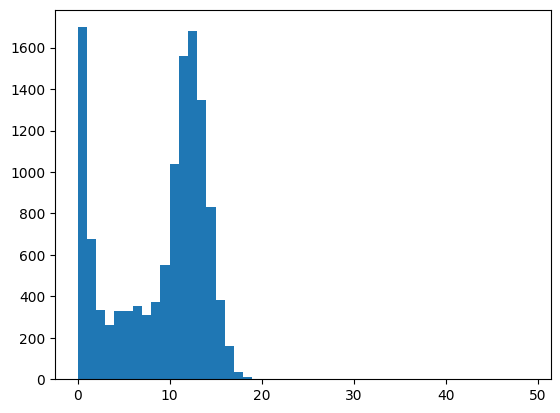

In [6]:
# draw the distribution of the number of hits per track
n_hits = [len(hits) for hits in track_hits.values()]

plt.hist(n_hits, bins=range(0, 50, 1))

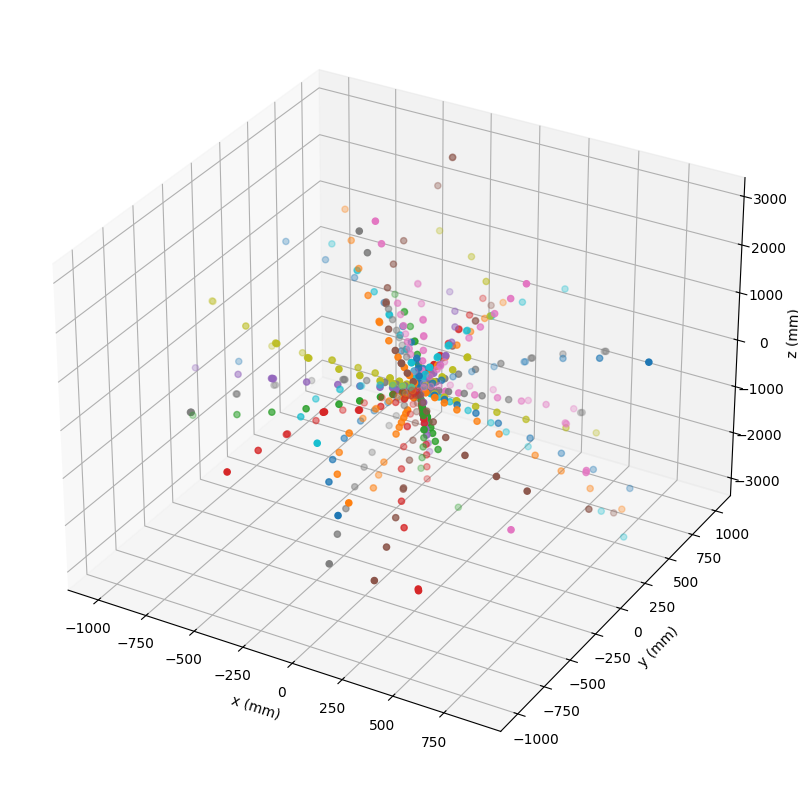

In [74]:
# draw the first N tracks
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

N_TRACKS = 50 

tracks = {}
for particle_id, track in dict(itertools.islice(track_hits.items(), N_TRACKS)).items():
    ax.scatter(track['x'], track['y'], track['z'], marker='o', label='particle_id: '+str(particle_id))

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
plt.show()

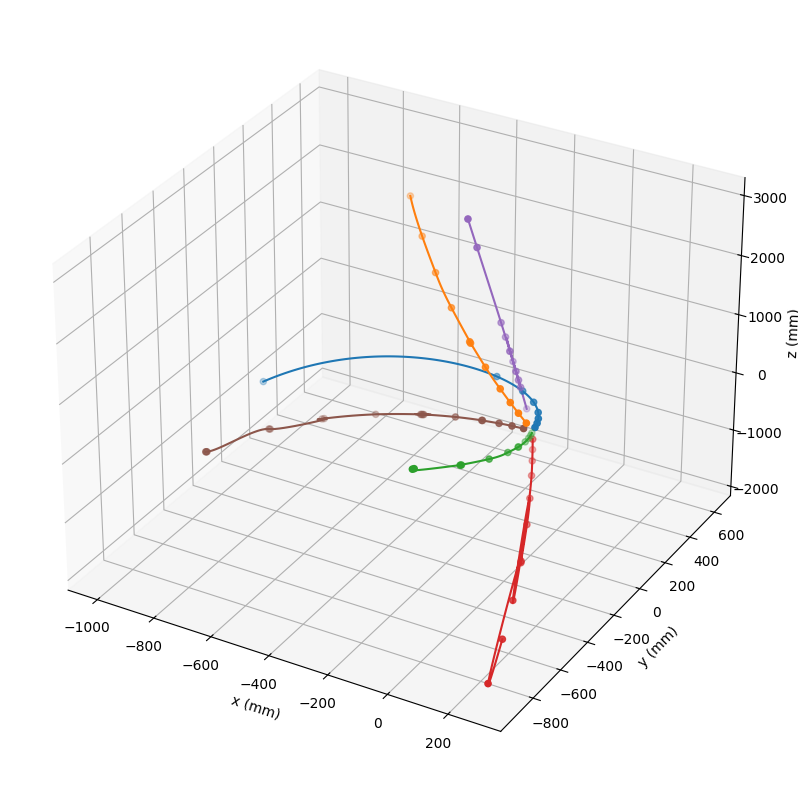

In [73]:
# draw and fit the first N tracks
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

N_TRACKS = 8

tracks = {}
for particle_id, track in dict(itertools.islice(track_hits.items(), N_TRACKS)).items():
    if track.shape[0] < 4:
        continue
    ax.scatter(track['x'], track['y'], track['z'], marker='o', label='particle_id: '+str(particle_id))
    x_data, y_data, z_data = track[['x', 'y', 'z']].values.T
    x_fit, y_fit, z_fit = fit_spline(x_data, y_data, z_data, smoothing_factor=0.5)
    ax.plot(x_fit, y_fit, z_fit, label='particle_id: '+str(particle_id))
    tracks[particle_id] = [x_fit, y_fit, z_fit]


ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
plt.show()

NOTE: with a number of points lesser than 4, the fit procedure does not work and the track is discarded here (just for the purpose of fitting). Moreover, a spline is sometimes overfitting and seems to struggle when there are multiple points close to each other (instead of fitting in between, it passes through all of them).

/Users/glucia/Projects/DeepLearning/TrackingML/core/geometry.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = module[0].split(',')


(-1500.0, -800.0)

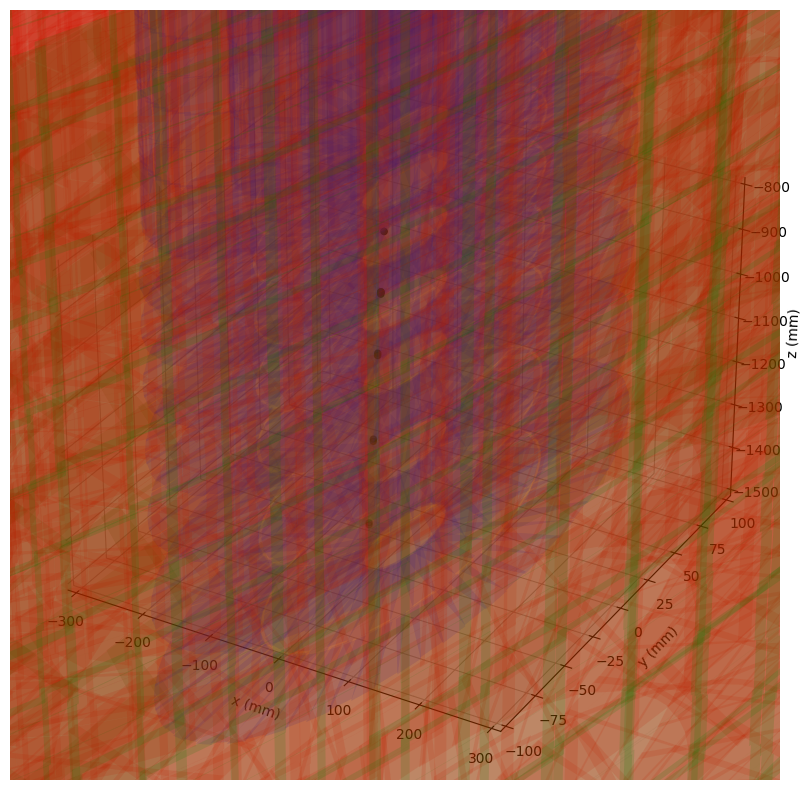

In [15]:
geometryFile = '../data/detectors.csv'
geometry = DetectorGeometry(geometryFile)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# plot the hits (strong colors and large markers)
ax.scatter(selected_hits['x'], selected_hits['y'], selected_hits['z'], c='k', marker='o', label='hits')
# plot the detector volumes
geometry.detector_display(ax, 'quiet', alpha=0.07)

ax.set_xlim(-300, 300)
ax.set_ylim(-100, 100)
ax.set_zlim(-1500, -800)

# Display reconstructed tracks

In [10]:
track_df = pd.read_csv('../../data/save/test_reco_tracks.csv')


Number of tracks: 2005


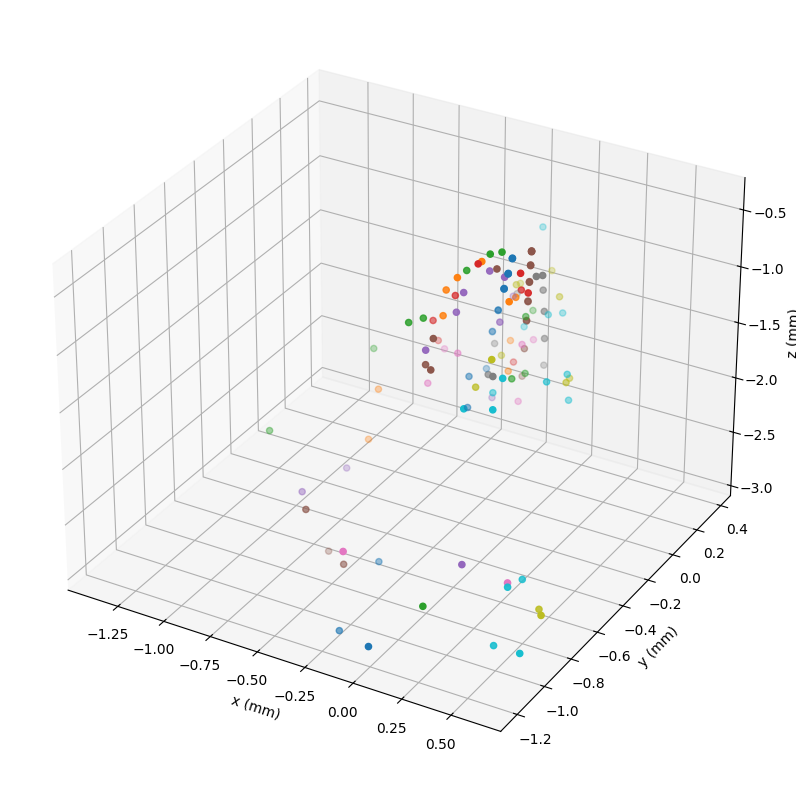

In [11]:
# reconstructed tracks

track_df.query('track_id != 0', inplace=True)

track_hits_dict = {}
for track_id in track_df['track_id'].unique():
    track_hits_dict[track_id] = [hit for hit in track_df.query(f'track_id == {track_id}')['hit_id']]
    
track_hits = {}
for track_id, hit_ids in track_hits_dict.items():
    track_hits[track_id] = track_df.query(f'hit_id in {hit_ids}')
print(tc.BOLD+'\nNumber of tracks:'+tc.RESET, len(track_hits))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

N_TRACKS = 20

tracks = {}
for track_id, track in dict(itertools.islice(track_hits.items(), N_TRACKS)).items():
    ax.scatter(track['x'], track['y'], track['z'], marker='o', label='track_id: '+str(track_id))

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
plt.show()


Number of tracks: 6487


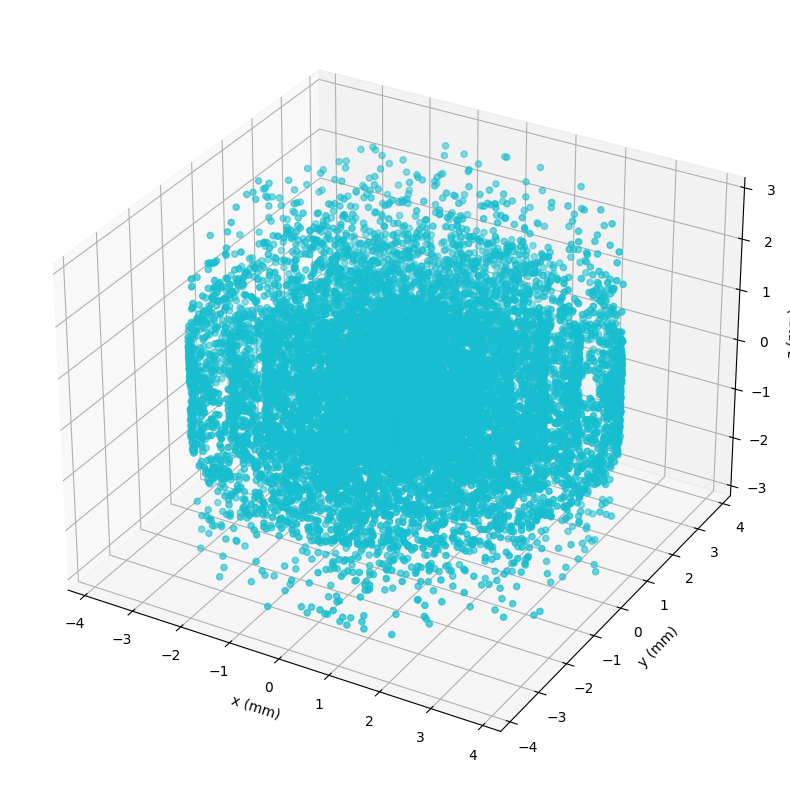

In [45]:
#track_df.query('particle_id != 0', inplace=True)

particle_hits_dict = {}
for particle_id in track_df['particle_id'].unique():
    particle_hits_dict[particle_id] = [hit for hit in track_df.query(f'particle_id == {particle_id}')['hit_id']]
    
track_hits = {}
for particle_id, hit_ids in particle_hits_dict.items():
    track_hits[particle_id] = track_df.query(f'hit_id in {hit_ids}')
print(tc.BOLD+'\nNumber of tracks:'+tc.RESET, len(track_hits))

# draw the first N tracks
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

N_TRACKS = 20 

tracks = {}
for particle_id, track in dict(itertools.islice(track_hits.items(), N_TRACKS)).items():
    ax.scatter(track['x'], track['y'], track['z'], marker='o', label='particle_id: '+str(particle_id))

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
plt.show()

Visualize track 1

In [36]:
def show_track(track_id, track_df):
    
    # clear the figure
    plt.clf()

    track = track_df.query(f'track_id == {track_id}')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for particle_id in track['particle_id'].unique():
        track_particle = track.query(f'particle_id == {particle_id}')
        ax.scatter(track_particle['x'], track_particle['y'], track_particle['z'], label='particle_id: '+str(particle_id))
    
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_zlabel('z (mm)')
    plt.legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

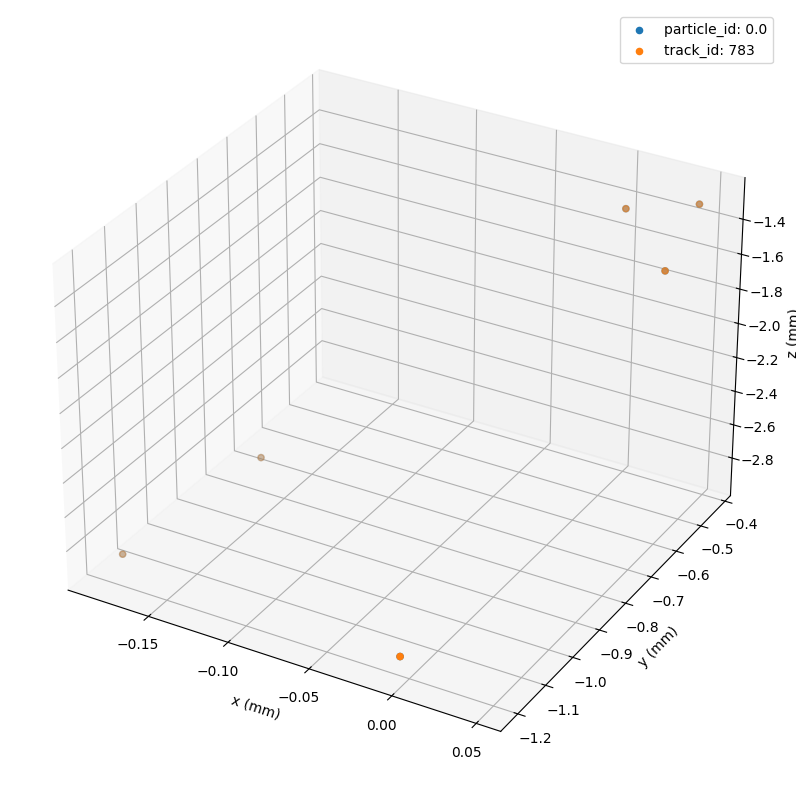

In [37]:
track_ids = track_df['track_id'].unique()

show_track(track_ids[10], track_df)

In [38]:
# select only tracks with unique particle_id that is not just 0

interesting_tracks = []
for track_id in track_df['track_id'].unique():
    track = track_df.query(f'track_id == {track_id}')
    if len(track['particle_id'].unique()) == 1 and track['particle_id'].unique()[0] == 0:
        pass
    else:
        interesting_tracks.append(track_id)


Interesting track
particle_id
4.504974e+15    14
0.000000e+00     4
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

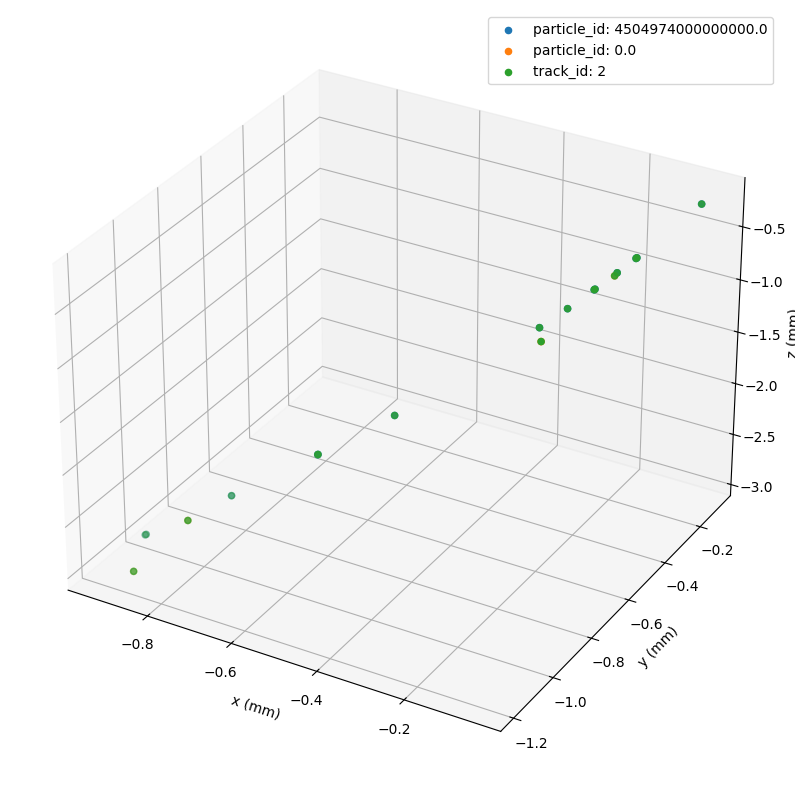

In [39]:
TRACK_IDX = 4

print(tc.BOLD+'\nInteresting track'+tc.RESET)
print(track_df.query(f'track_id == {interesting_tracks[TRACK_IDX]}')['particle_id'].value_counts())

show_track(interesting_tracks[TRACK_IDX], track_df) 

